<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Sajjad Hashembeiki
### Student ID: 98107077

# Import necessary libraries

In [1]:
# Import libraries
import tqdm
import torch
import random
import torchvision

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the MNIST dataset and data loader

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 102254130.05it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 18109686.62it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 31084055.00it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1254479.70it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [3]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

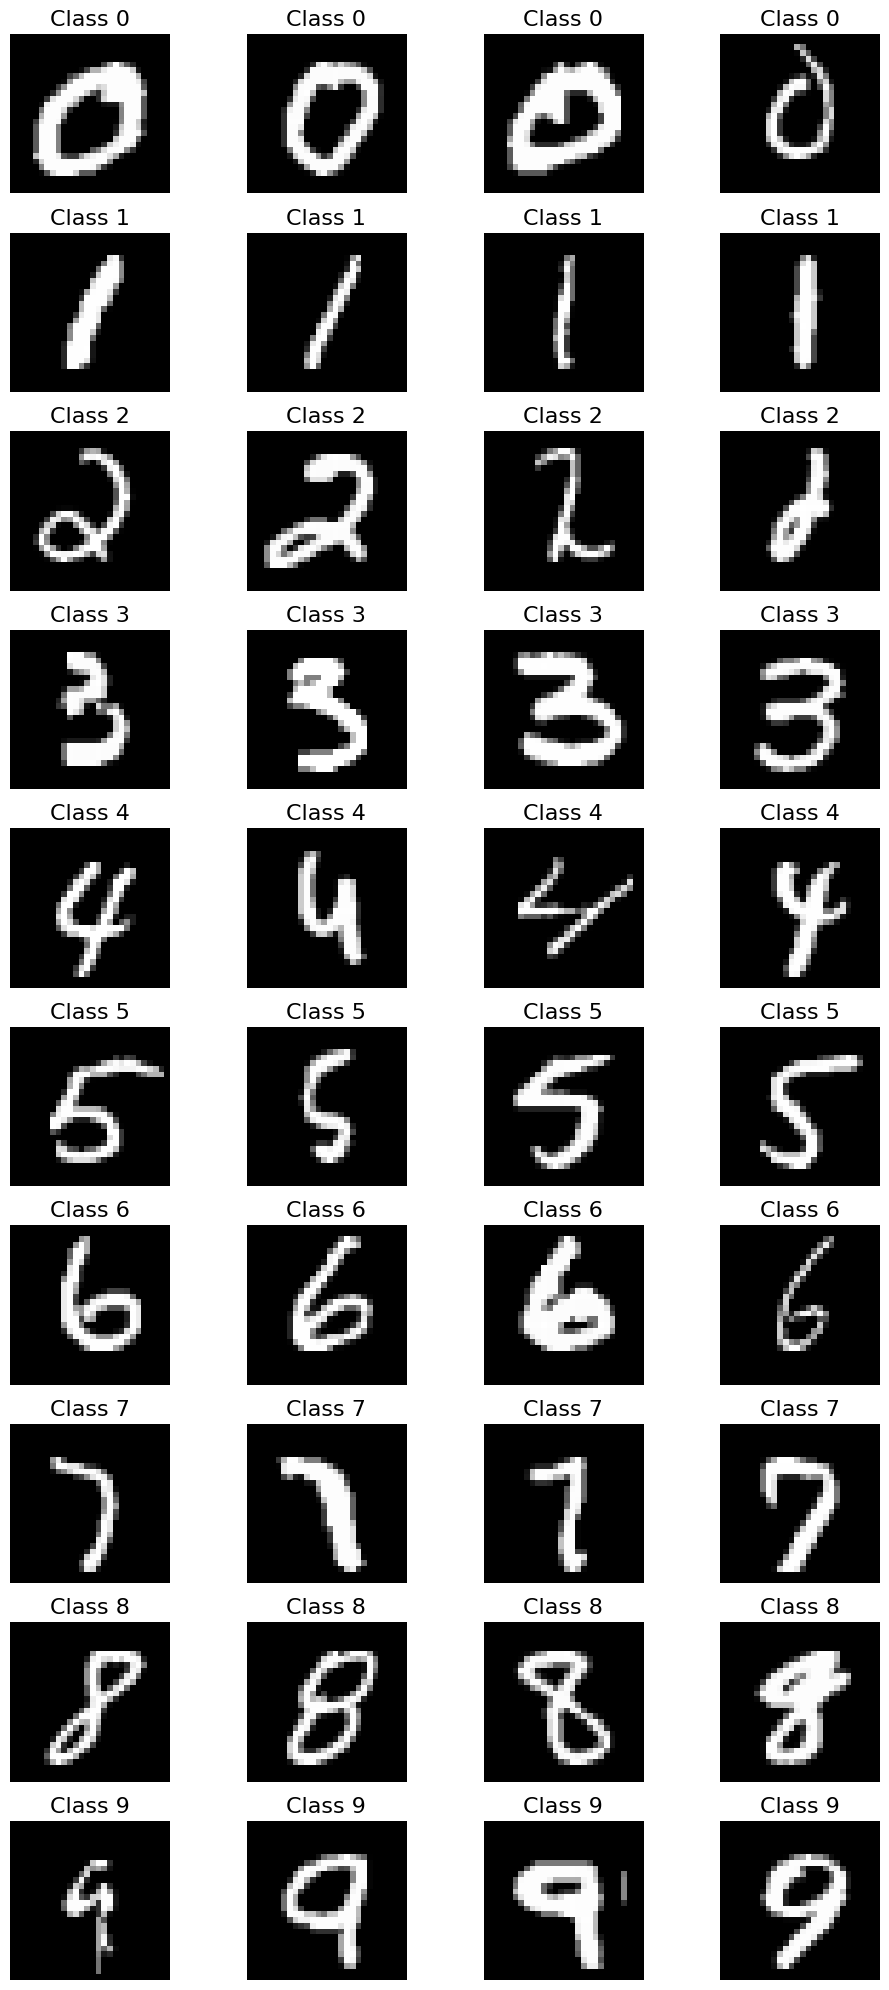

In [4]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [51]:
# Define a simple VAE class with MLP architecture
class VAE_MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=8, latent_dim=2):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            # TODO: Add layers for the encoder
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU())

        self.fc_mu = nn.Linear(8, 2)
        self.fc_logvar = nn.Linear(8, 2)

        self.decoder = nn.Sequential(
            # TODO: Add layers for the decoder
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        # TODO: Implement the reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # TODO: Implement the forward pass
        # Encoder
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)

        # Reparameterization
        z = self.reparameterize(mu, logvar)

        # Decoder
        x_recon = self.decoder(z)

        return x_recon, mu, logvar

In [52]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.BCELoss(reduction='sum')(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [53]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [54]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in tqdm.tqdm(enumerate(train_loader)):
            # TODO: Forward process
            data = data.reshape(-1,784).to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon_batch, data, mu, logvar)

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss/ len(train_loader.dataset)
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2).to(device)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")


##################################################


938it [00:10, 93.70it/s]


VAE-MLP Epoch [1/10], Loss: 200.19293459472655
Sample Images:


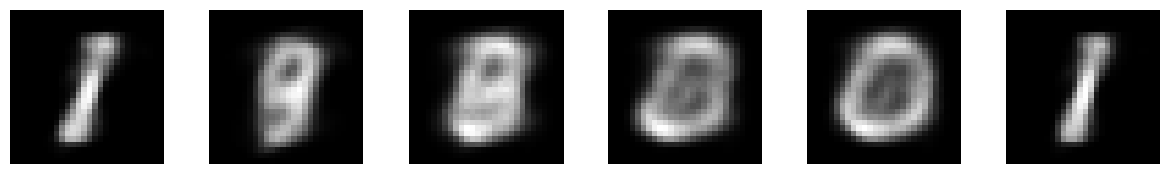


##################################################


938it [00:10, 93.35it/s]


VAE-MLP Epoch [2/10], Loss: 169.98163444010416
Sample Images:


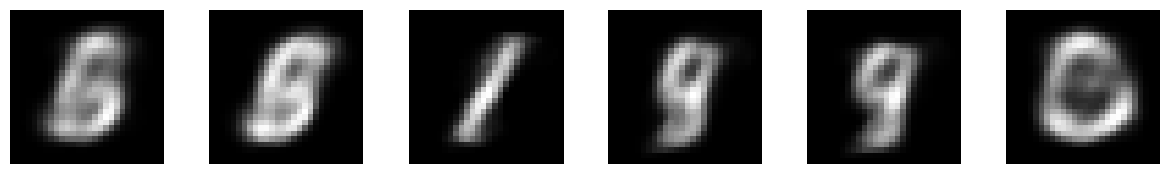


##################################################


938it [00:10, 89.40it/s]


VAE-MLP Epoch [3/10], Loss: 164.14559991861978
Sample Images:


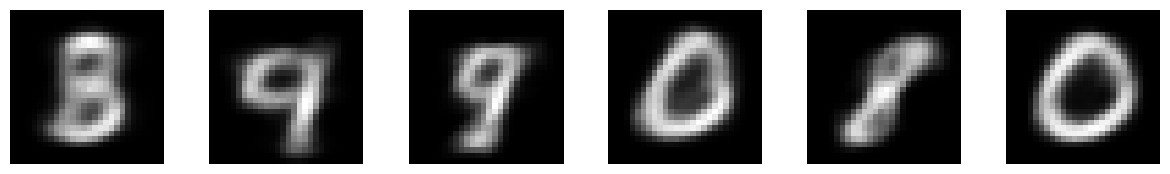


##################################################


938it [00:10, 90.25it/s]


VAE-MLP Epoch [4/10], Loss: 160.49432040201822
Sample Images:


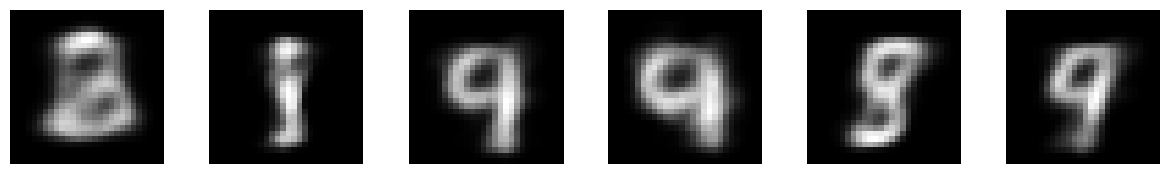


##################################################


938it [00:10, 89.45it/s]


VAE-MLP Epoch [5/10], Loss: 157.70236235351564
Sample Images:


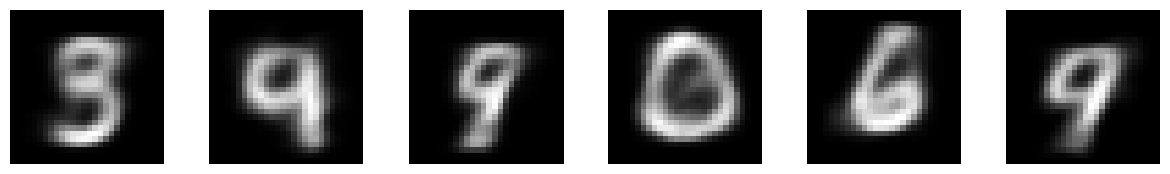


##################################################


938it [00:10, 89.42it/s]


VAE-MLP Epoch [6/10], Loss: 155.63570106608074
Sample Images:


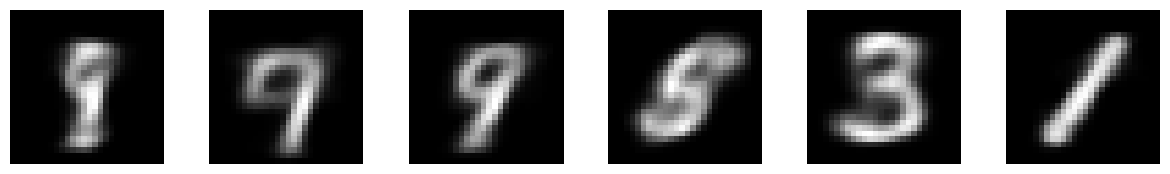


##################################################


938it [00:09, 94.84it/s]


VAE-MLP Epoch [7/10], Loss: 153.99316544596354
Sample Images:


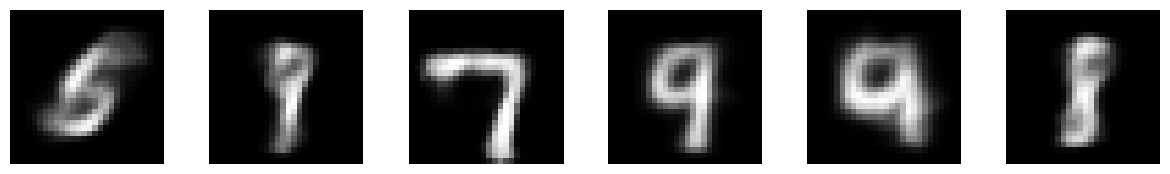


##################################################


938it [00:10, 90.58it/s]


VAE-MLP Epoch [8/10], Loss: 152.55457669270834
Sample Images:


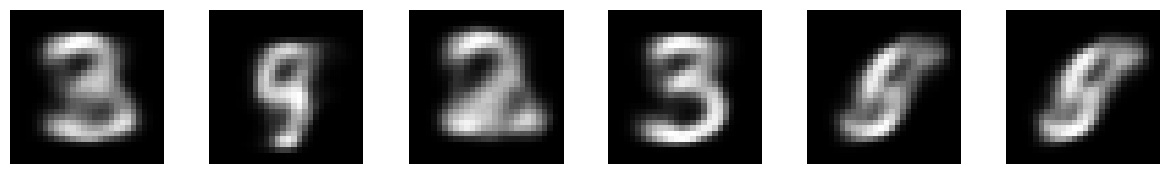


##################################################


938it [00:10, 90.63it/s] 


VAE-MLP Epoch [9/10], Loss: 151.54342419433593
Sample Images:


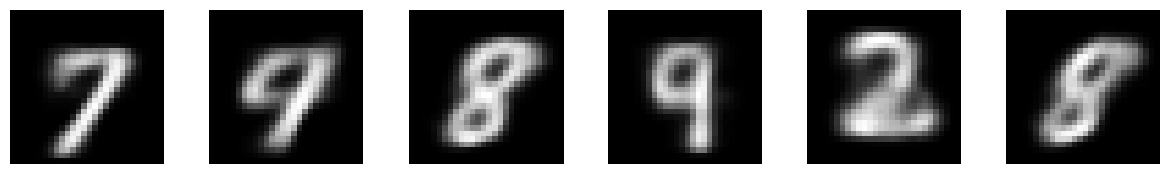


##################################################


938it [00:10, 89.27it/s]


VAE-MLP Epoch [10/10], Loss: 150.5369453450521
Sample Images:


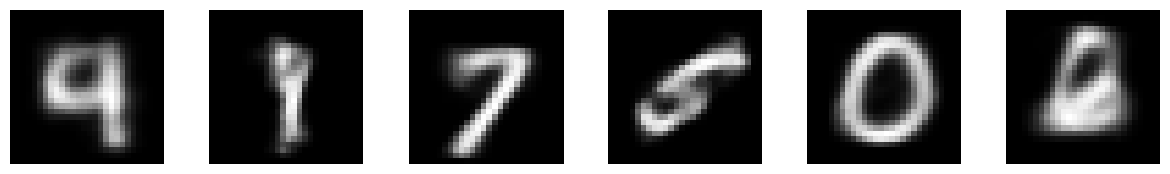

Best model saved as 'best_vae_mlp_model.pth'


In [55]:
# Train VAE-MLP
vae_mlp = VAE_MLP(input_dim=784, hidden_dim=8, latent_dim=2).to(device)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [56]:
class CVAE_MLP(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=128, latent_dim=2, num_classes=10):
        super(CVAE_MLP, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + num_classes, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        self.fc_class = nn.Linear(16, num_classes)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], dim=1)

        # Encoder
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        z = self.reparameterize(mu, logvar)
        class_logits = self.fc_class(hidden)

        # Concatenate latent vector and label for decoding
        z_with_label = torch.cat([z, y], dim=1)

        # Decoder
        reconstructed = self.decoder(z_with_label)

        return reconstructed, mu, logvar, class_logits

In [57]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # Flatten the data tensor
    data = data.view(data.size(0), -1)

    # Reconstruction loss (BCE)
    reconstruction_loss = nn.BCELoss(reduction='sum')(recon, data)

    # KL divergence loss
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Cross-entropy loss for class prediction
    ce_loss = nn.CrossEntropyLoss()(class_logits, labels)

    # Total loss
    total_loss = reconstruction_loss + kl_divergence + ce_loss

    return total_loss

In [58]:
# One-hot encoding function for digit labels
def one_hot_encode(labels, num_classes):
    encoded = torch.zeros(len(labels), num_classes)
    encoded.scatter_(1, labels.view(-1, 1), 1)
    return encoded.to(device)

In [59]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None

    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, labels) in tqdm.tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            # One-hot encode the labels
            labels_one_hot = one_hot_encode(labels, 10).to(device)
            data = data.reshape(-1,784).to(device)

            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, logvar, class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, logvar, class_logits, labels.to(device))

            # TODO: Backpropagation and optimization step
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss/ len(train_loader.dataset)
        print(' ')
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample.to(device)).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model.state_dict()

    # TODO: Save the best model to a file
    torch.save(best_model, 'best_cvae_mlp_model.pth')
    print("Best model saved as 'best_cvae_mlp_model.pth'")


##################################################


938it [00:10, 86.52it/s]


 
CVAE-MLP Epoch [1/10], Loss: 191.60080091145832
Sample Images:


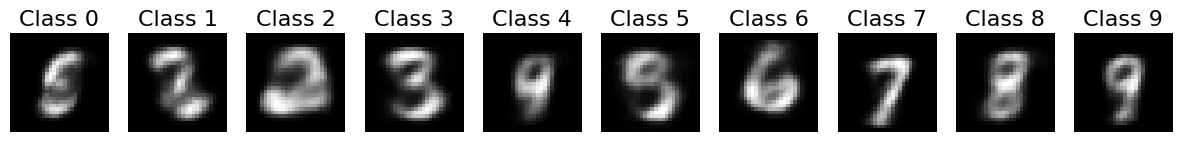


##################################################


938it [00:10, 86.82it/s]


 
CVAE-MLP Epoch [2/10], Loss: 151.12183238932292
Sample Images:


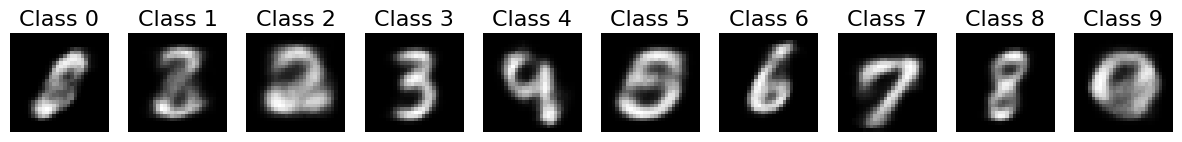


##################################################


938it [00:11, 85.20it/s]


 
CVAE-MLP Epoch [3/10], Loss: 143.78228053385416
Sample Images:


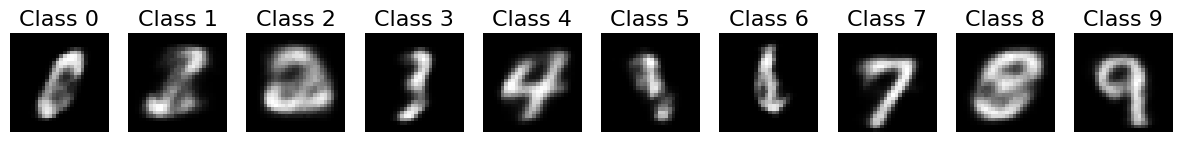


##################################################


938it [00:10, 89.29it/s]


 
CVAE-MLP Epoch [4/10], Loss: 140.3871595703125
Sample Images:


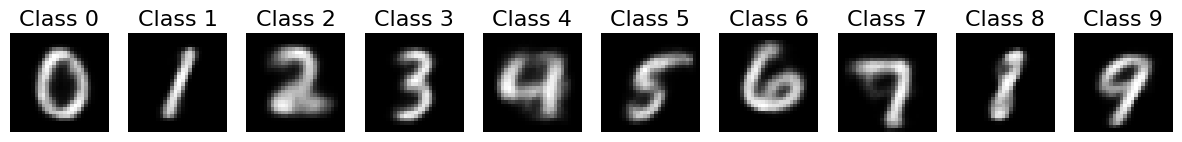


##################################################


938it [00:10, 88.79it/s]


 
CVAE-MLP Epoch [5/10], Loss: 138.53610093587238
Sample Images:


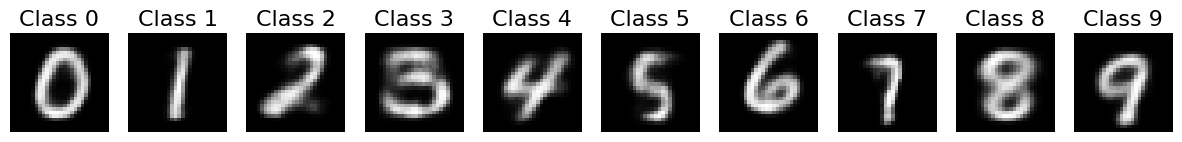


##################################################


938it [00:10, 86.07it/s]


 
CVAE-MLP Epoch [6/10], Loss: 137.25424021809897
Sample Images:


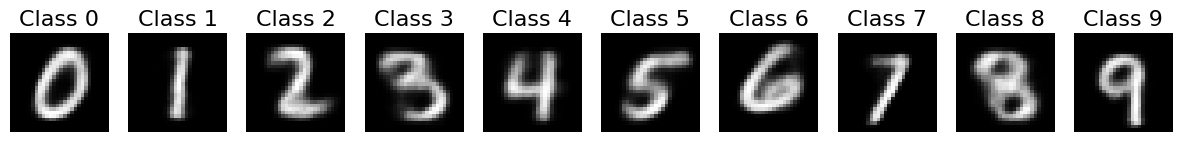


##################################################


938it [00:10, 85.30it/s]


 
CVAE-MLP Epoch [7/10], Loss: 136.2256056233724
Sample Images:


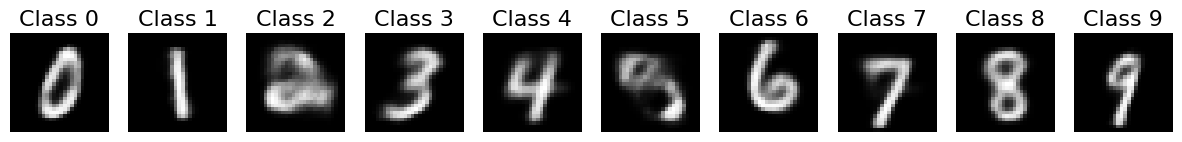


##################################################


938it [00:11, 84.64it/s]


 
CVAE-MLP Epoch [8/10], Loss: 135.44505193684896
Sample Images:


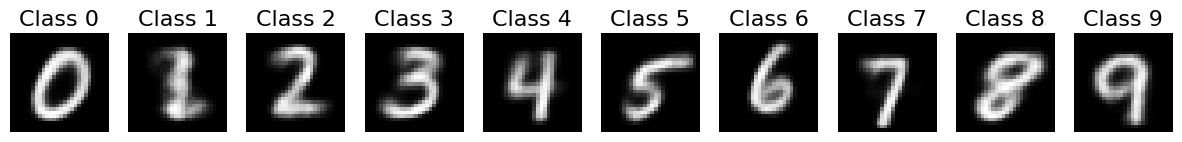


##################################################


938it [00:11, 83.18it/s]


 
CVAE-MLP Epoch [9/10], Loss: 134.83939775390624
Sample Images:


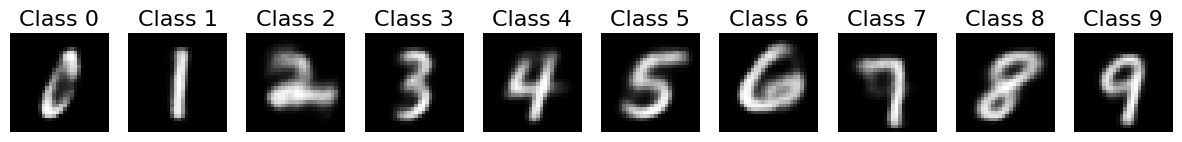


##################################################


938it [00:11, 78.33it/s]


 
CVAE-MLP Epoch [10/10], Loss: 134.29073721516926
Sample Images:


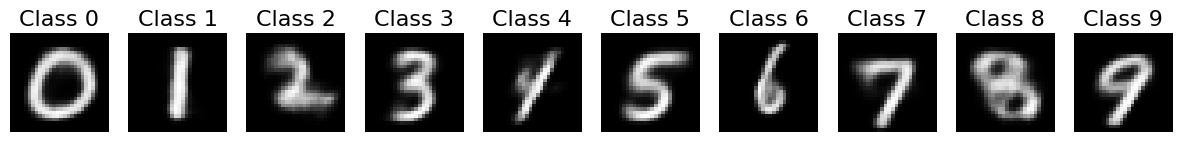

Best model saved as 'best_cvae_mlp_model.pth'


In [60]:
cvae_mlp = CVAE_MLP(input_dim=784, hidden_dim=128, latent_dim=2, num_classes=10).to(device)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


# Latent Space Distribution

## VAE (MLP):

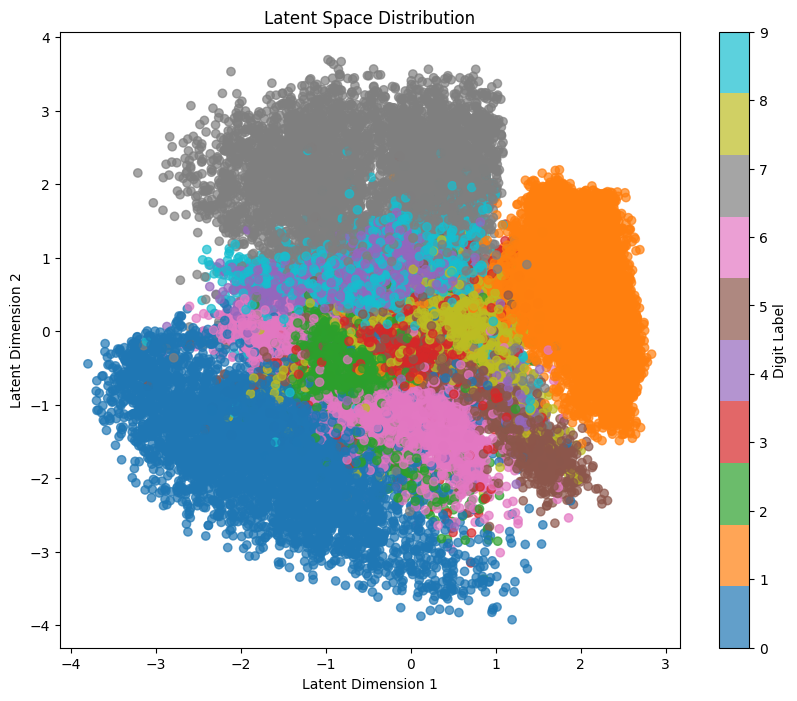

In [61]:
# Function to visualize the latent space distribution
def visualize_latent_space(model, data_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.reshape(-1,784).to(device)
            _, mu, _ = model(data)
            latent_vectors.append(mu.cpu())
            labels.append(target)

    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)

    # Plot the latent space distribution
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.title('Latent Space Distribution')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Visualize latent space distribution
visualize_latent_space(vae_mlp, train_loader)

## CVAE (MLP):

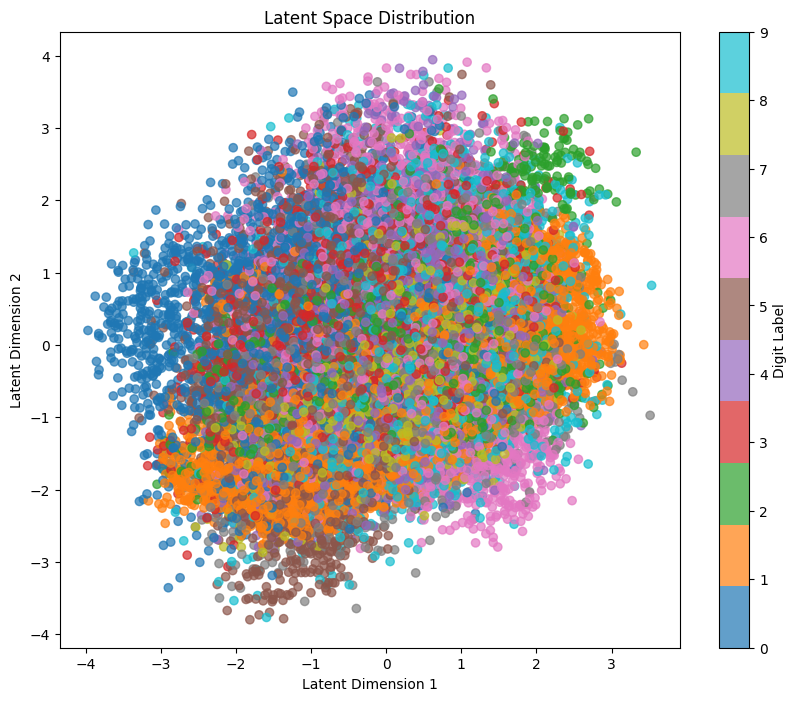

In [62]:
# Function to visualize the latent space distribution
def visualize_latent_space(model, data_loader):
    model.eval()
    latent_vectors = []
    labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.reshape(-1,784).to(device)
            labels_one_hot = one_hot_encode(target, 10).to(device)
            _, mu, _, _ = model(data, labels_one_hot)
            latent_vectors.append(mu.cpu())
            labels.append(target)

    latent_vectors = torch.cat(latent_vectors, dim=0)
    labels = torch.cat(labels, dim=0)

    # Plot the latent space distribution
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.colorbar(scatter, label='Digit Label')
    plt.title('Latent Space Distribution')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.show()

# Visualize latent space distribution
visualize_latent_space(cvae_mlp, train_loader)

# VAE and CVAE Comparison

### As you see in the latent space of VAE, the model needs to create a space that the classes are discriminative, because the model does not have any label or condition.

### But in CAVE,  the classes in latent space are not discriminative and they are inseparable . Actually the model uses the condition of each class to recognize the class and generate a sample from that.